In [11]:
import matplotlib.pyplot as plt
import os, pickle
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.special import gamma, digamma

In [12]:
def compute_KL(a1,b1,a2,b2): #be aware that KL divergence is not symmetric
    # compute normalization function
    B_a1b1 = gamma(a1)*gamma(b1)/gamma(a1+b1)
    B_a2b2 = gamma(a2)*gamma(b2)/gamma(a2+b2)
    term0 = np.log(B_a2b2/B_a1b1 )
    term1 = (a1-a2)*digamma(a1)
    term2 = (b1-b2)*digamma(b1)
    term3 = (a2-a1+b2-b1)*digamma(a1+b1)
    all = term0 + term1 + term2 + term3
    return all

In [13]:
## load results

path = '/home/kt14/workbench/proxy_latent_shifts/tests/sim_multisource_v2/sweep_results/'

i = 9
baseline = pd.read_csv(path+f'sweep_baseline_v2_v4_seeds{i}.csv')

proposed_all = pd.DataFrame()

for i in range(10):
    df = pd.read_csv(path+f'sweep_proposed_v2_fixscaleseed{i}.csv')
    df['seed'] = i
    proposed_all = pd.concat([proposed_all, df])

baseline.loc[baseline['approach'] == 'multisource uniform', 'approach'] = 'Avg-ERM'
baseline.loc[baseline['approach'] == 'multisource cat', 'approach']     = 'Cat-ERM'
baseline.loc[baseline['approach'] == 'multisource simple aadapt', 'approach']     = 'SA'


oracle = baseline[baseline['approach'] == 'ERM'][['approach', 'target -> target', 'pU=0', 'seed']]
oracle.loc[oracle['approach']=='ERM', 'approach'] = 'ORACLE'
oracle = oracle.rename(columns={'target -> target': 'MSE'})

baseline = baseline.drop('source -> source', axis = 1)
baseline = baseline.drop('target -> target', axis = 1)
baseline = baseline.drop('target -> source', axis = 1)
baseline = baseline.rename(columns={'source -> target': 'MSE'})


proposed_all.loc[proposed_all['task'] == 'adaptation', 'task'] = 'Proposed' 




all_summary = proposed_all[proposed_all['task'] == 'Proposed']
all_summary = all_summary.rename(columns={'predict error.l2': 'MSE', 'task':'approach'})
all_summary = all_summary.drop('env_id', axis=1)

all_summary = pd.concat([all_summary, baseline, oracle])

In [25]:
all_df = pd.DataFrame()
change_name = {
    'ERM': 'ERM', 
    'COVAR': 'COVAR', 
    'LABEL': 'LABEL', 
    'multisource uniform': 'Avg-ERM', 
    'multisource cat': 'Cat-ERM', 
    'multisource simple aadapt': 'SA'
}
path = '/home/kt14/workbench/proxy_latent_shifts/tests/sim_multisource_cont/results/'
for i in range(10):
    df_proposed = pd.read_csv(path+f'sweep_proposed_v2_seed{i}.csv')
    df_baseline = pd.read_csv(path+f'sweep_baseline_seed{i}.csv')
    for item in df_proposed[df_proposed['task']=='adaptation'].values:
        a1 = item[3]
        b1 = item[4]
        d1 = compute_KL(a1,b1,2,4)
        d2 = compute_KL(a1,b1,4,2)
        diff  =  item[2] - df_proposed[(df_proposed['task']=='target-target') & (df_proposed['a']==item[3]) & (df_proposed['b']==item[4])]['predict error.l2'].values[0]
        diff2 =  item[2] - df_baseline[(df_baseline['approach']=='ERM') & (df_baseline['a']==item[3]) & (df_baseline['b']==item[4])]['target -> target'].values[0]
        new_dict = {
            'approach': 'Proposed',
            'MSE':  item[2],
            'a':    item[3],
            'b':    item[4],
            'kl1': d1,
            'kl2': d2,
            'offset': diff,
            'offset2': diff2,
            'seed': i
        }
        
        all_df = pd.concat([all_df, pd.DataFrame.from_dict([new_dict])], ignore_index=True)
    
    for approach in ['ERM', 'COVAR', 'LABEL', 'multisource uniform', 'multisource cat', 'multisource simple aadapt']:
        for item in df_baseline[df_baseline['approach'] == approach].values:
    
            a1 = item[5]
            b1 = item[6]
            d1 = compute_KL(a1,b1,2,4)
            d2 = compute_KL(a1,b1,4,2)
            diff  =  item[2] - df_proposed[(df_proposed['task']=='target-target') & (df_proposed['a']==a1) & (df_proposed['b']==b1)]['predict error.l2'].values[0]
            diff2 =  item[2] - df_baseline[(df_baseline['approach']=='ERM') & (df_baseline['a']==a1) & (df_baseline['b']==b1)]['target -> target'].values[0]
            new_dict = {
                'approach':change_name[item[0]],
                'MSE':  item[2],
                'a':    item[5],
                'b':    item[6],
                'kl1': d1,
                'kl2': d2,
                'offset': diff,
                'offset2': diff2,
                'seed': i
            }
            all_df = pd.concat([all_df, pd.DataFrame.from_dict([new_dict])], ignore_index=True)
    for item in df_baseline[df_baseline['approach'] == 'ERM'].values:

        a1 = item[5]
        b1 = item[6]
        d1 = compute_KL(a1,b1,2,4)
        d2 = compute_KL(a1,b1,4,2)
        diff  =  item[3] - df_proposed[(df_proposed['task']=='target-target') & (df_proposed['a']==a1) & (df_proposed['b']==b1)]['predict error.l2'].values[0]
        diff2 =  0
        new_dict = {
            'approach':'ORACLE',
            'MSE':  item[3],
            'a':    item[5],
            'b':    item[6],
            'kl1': d1,
            'kl2': d2,
            'offset': diff,
            'offset2': diff2,
            'seed': i
        }
        all_df = pd.concat([all_df, pd.DataFrame.from_dict([new_dict])], ignore_index=True)

#path = './results/'
##for i in range(10):
#    df = pd.read_csv(path+f'sweep_baseline_v2_seed{i}.csv')
    

In [26]:
all_df['approach'].unique()

array(['Proposed', 'ERM', 'COVAR', 'LABEL', 'Avg-ERM', 'Cat-ERM', 'SA',
       'ORACLE'], dtype=object)

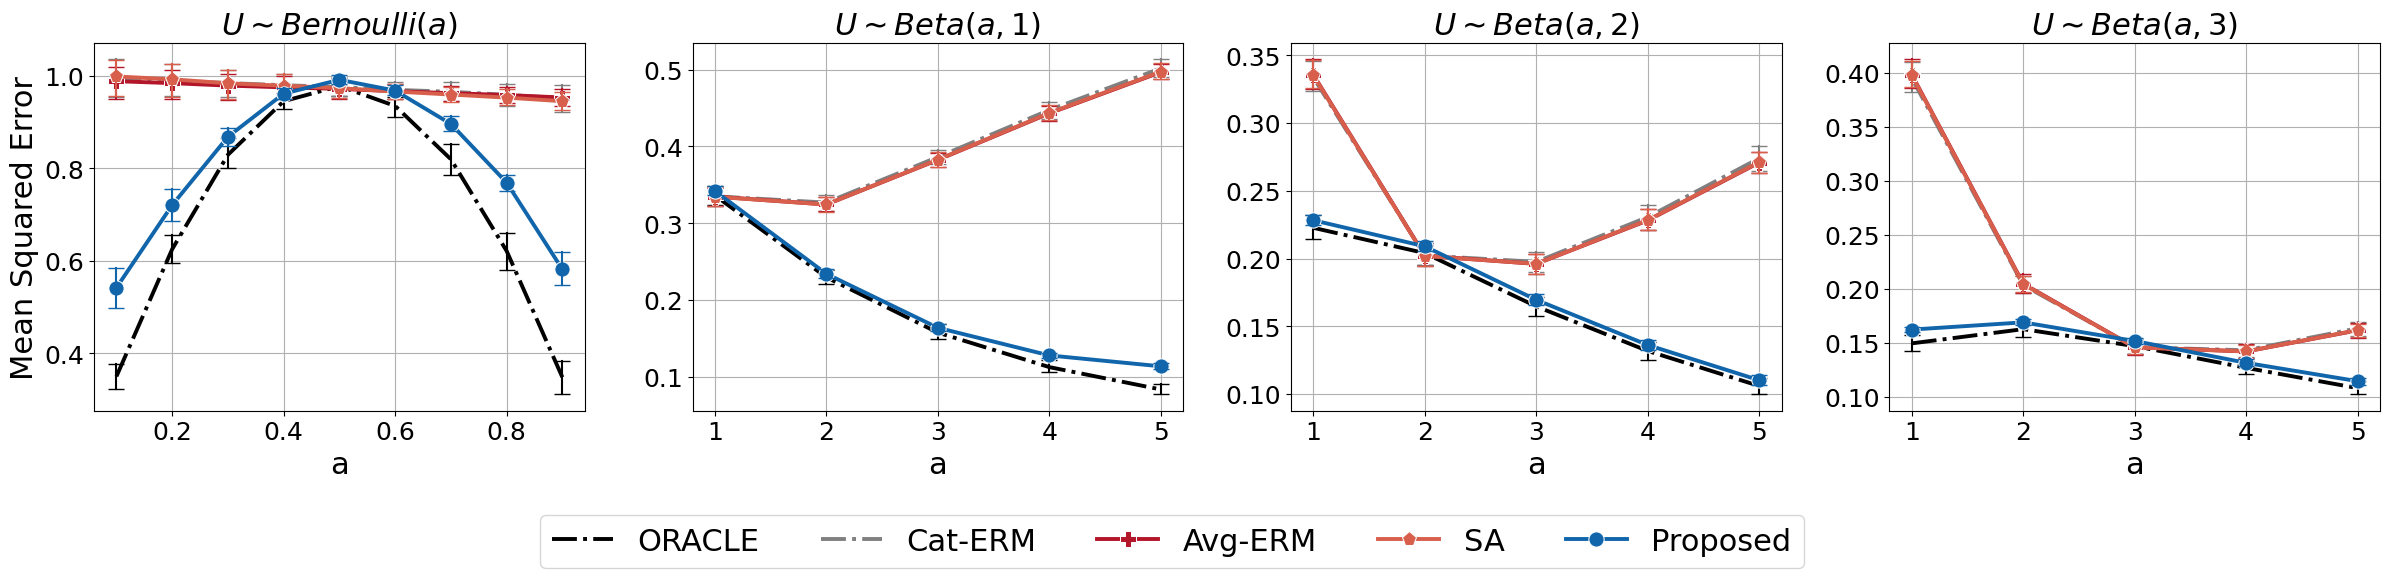

In [51]:
format_set = [
    {'color': 'black',   'linestyle': 'dashdot', 'marker': None },
    {'color': 'grey',    'linestyle': 'dashdot', 'marker': None },
    {'color': '#b31529', 'linestyle': 'solid',   'marker': 'P'},
    {'color': '#d75f4c', 'linestyle': 'solid',   'marker': 'p'},
    {'color': '#d7864c', 'linestyle': 'solid',   'marker': 'x'},
    {'color': '#3A93C3', 'linestyle': 'solid',   'marker': 'd'},
    {'color': '#1065ab', 'linestyle': 'solid',   'marker': 'o'}
]


tick_size = 18
label_size = 22
linewidth=2.8
capsize=6
markersize=11
fig, axes = plt.subplots(1, 4, figsize=(24, 5))




style_dict = {
'ORACLE':   {'line_style': format_set[0]['linestyle'], 'marker': format_set[0]['marker'], 'color':format_set[0]['color']},
'Cat-ERM':      {'line_style': format_set[1]['linestyle'], 'marker': format_set[1]['marker'], 'color':format_set[1]['color']},
'Avg-ERM':  {'line_style': format_set[2]['linestyle'], 'marker': format_set[2]['marker'], 'color':format_set[2]['color']},
#'LABEL':  {'line_style': format_set[2]['linestyle'], 'marker': format_set[2]['marker'], 'color':format_set[2]['color']},
'SA':       {'line_style': format_set[3]['linestyle'], 'marker': format_set[3]['marker'], 'color':format_set[3]['color']},
'Proposed': {'line_style': format_set[6]['linestyle'], 'marker': format_set[6]['marker'], 'color':format_set[6]['color']},
}


for approach, style in style_dict.items():
    subset = all_summary[all_summary['approach'] == approach]
    sns.lineplot(data=subset.sort_values(by=['pU=0']), x='pU=0', y='MSE', label=approach, color=style['color'], ax=axes[0], legend=False,
                 linestyle=style['line_style'],err_kws={'capsize': capsize}, err_style="bars", marker=style['marker'], markersize=markersize, linewidth=linewidth)
    





for approach, style in style_dict.items():
    subset = all_df[(all_df['approach']==approach)  & (all_df['b']==1)]
    sns.lineplot(data=subset.sort_values(by=['a']), x='a', y='MSE', label=approach, color=style['color'], ax=axes[1], legend=False,
                 linestyle=style['line_style'],err_kws={'capsize': capsize}, err_style="bars", marker=style['marker'], markersize=markersize, linewidth=linewidth)
    




for approach, style in style_dict.items():
    subset = all_df[(all_df['approach']==approach)  & (all_df['b']==2)]
    sns.lineplot(data=subset.sort_values(by=['a']), x='a', y='MSE', label=approach, color=style['color'], ax=axes[2], legend=False,
                 linestyle=style['line_style'],err_kws={'capsize': capsize}, err_style="bars", marker=style['marker'], markersize=markersize, linewidth=linewidth)
    






for approach, style in style_dict.items():
    subset = all_df[(all_df['approach']==approach)  & (all_df['b']==3)]
    sns.lineplot(data=subset.sort_values(by=['a']), x='a', y='MSE', label=approach, color=style['color'], ax=axes[3], legend=False,
                 linestyle=style['line_style'],err_kws={'capsize': capsize}, err_style="bars", marker=style['marker'], markersize=markersize, linewidth=linewidth)
    


for i in range(4):
    axes[i].grid()
    axes[i].tick_params(axis='both', which='major', labelsize=tick_size)
    if i > 0:
        axes[i].set_ylabel("")

axes[0].set_xlabel('a',                      fontsize=label_size)
axes[1].set_xlabel('a',                      fontsize=label_size)
axes[2].set_xlabel('a',                      fontsize=label_size)
axes[3].set_xlabel('a',                      fontsize=label_size)
axes[0].set_ylabel('Mean Squared Error',     fontsize=label_size)
axes[0].set_title(r'$U\sim Bernoulli(a)$',   fontsize=label_size)
axes[1].set_title(r'$U\sim Beta(a,1)$', fontsize=label_size)
axes[2].set_title(r'$U\sim Beta(a,2)$', fontsize=label_size)
axes[3].set_title(r'$U\sim Beta(a,3)$', fontsize=label_size)

lines2, labels2 = axes[3].get_legend_handles_labels()


fig.legend(lines2, labels2, bbox_to_anchor=(.76,-0.01), ncol=5, fontsize=label_size)
fig.tight_layout()
plt.subplots_adjust(
                    wspace=0.22, 
                    hspace=0.1)

plt.savefig('regression result.pdf', bbox_inches='tight')



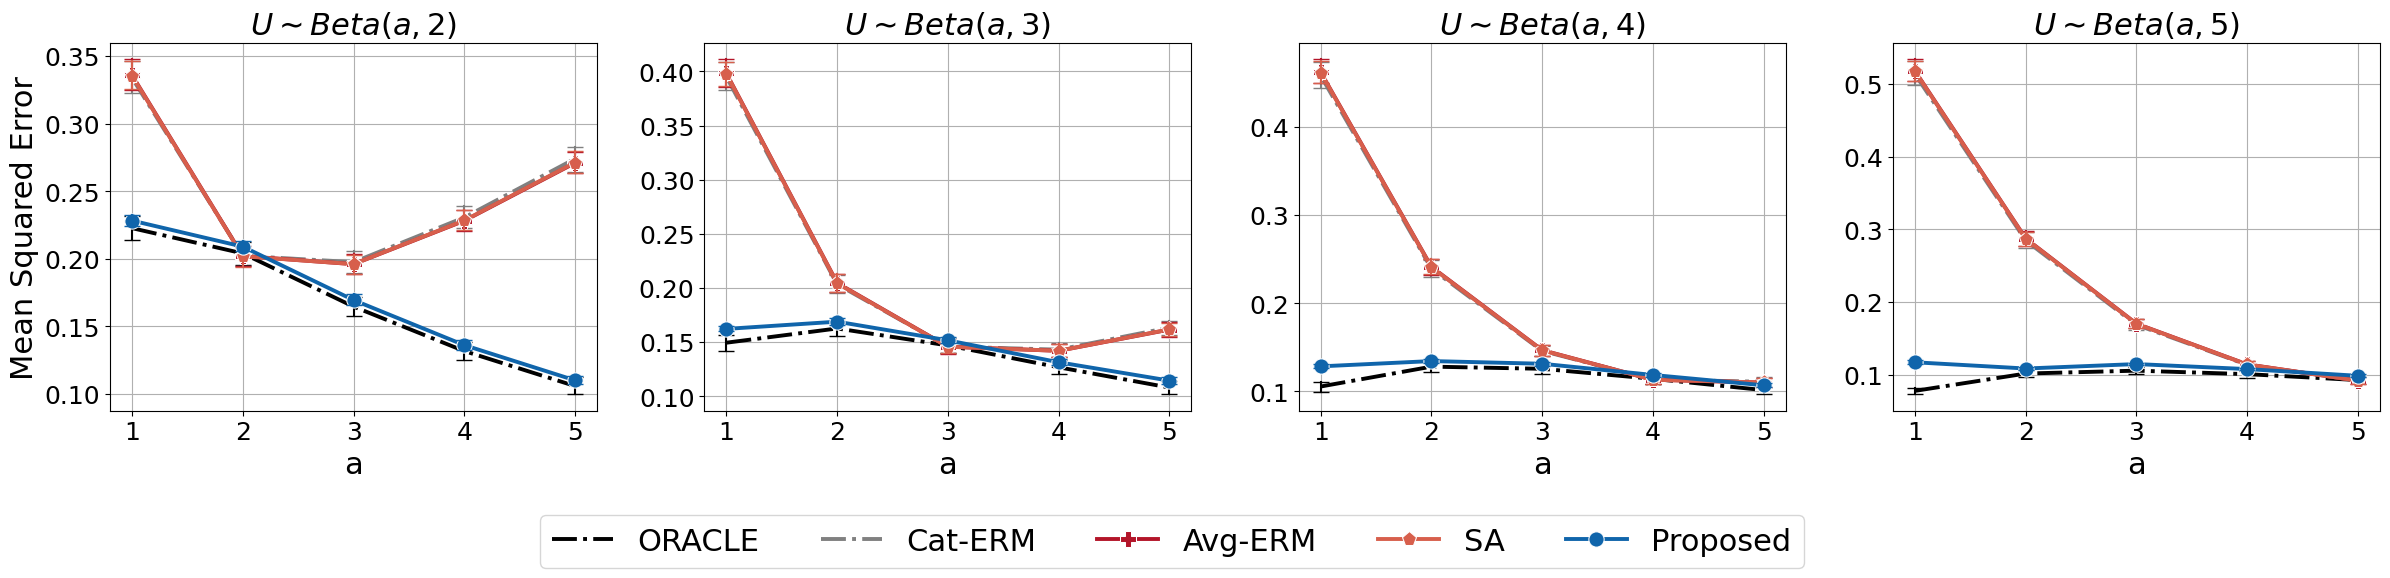

In [52]:
format_set = [
    {'color': 'black',   'linestyle': 'dashdot', 'marker': None },
    {'color': 'grey',    'linestyle': 'dashdot', 'marker': None },
    {'color': '#b31529', 'linestyle': 'solid',   'marker': 'P'},
    {'color': '#d75f4c', 'linestyle': 'solid',   'marker': 'p'},
    {'color': '#d7864c', 'linestyle': 'solid',   'marker': 'x'},
    {'color': '#3A93C3', 'linestyle': 'solid',   'marker': 'd'},
    {'color': '#1065ab', 'linestyle': 'solid',   'marker': 'o'}
]


tick_size = 18
label_size = 22
linewidth=2.8
capsize=6
markersize=11
fig, axes = plt.subplots(1, 4, figsize=(24, 5))




style_dict = {
'ORACLE':   {'line_style': format_set[0]['linestyle'], 'marker': format_set[0]['marker'], 'color':format_set[0]['color']},
'Cat-ERM':      {'line_style': format_set[1]['linestyle'], 'marker': format_set[1]['marker'], 'color':format_set[1]['color']},
'Avg-ERM':  {'line_style': format_set[2]['linestyle'], 'marker': format_set[2]['marker'], 'color':format_set[2]['color']},
#'LABEL':  {'line_style': format_set[2]['linestyle'], 'marker': format_set[2]['marker'], 'color':format_set[2]['color']},
'SA':       {'line_style': format_set[3]['linestyle'], 'marker': format_set[3]['marker'], 'color':format_set[3]['color']},
'Proposed': {'line_style': format_set[6]['linestyle'], 'marker': format_set[6]['marker'], 'color':format_set[6]['color']},
}



for approach, style in style_dict.items():
    subset = all_df[(all_df['approach']==approach)  & (all_df['b']==2)]
    sns.lineplot(data=subset.sort_values(by=['a']), x='a', y='MSE', label=approach, color=style['color'], ax=axes[0], legend=False,
                 linestyle=style['line_style'],err_kws={'capsize': capsize}, err_style="bars", marker=style['marker'], markersize=markersize, linewidth=linewidth)
    






for approach, style in style_dict.items():
    subset = all_df[(all_df['approach']==approach)  & (all_df['b']==3)]
    sns.lineplot(data=subset.sort_values(by=['a']), x='a', y='MSE', label=approach, color=style['color'], ax=axes[1], legend=False,
                 linestyle=style['line_style'],err_kws={'capsize': capsize}, err_style="bars", marker=style['marker'], markersize=markersize, linewidth=linewidth)
    




for approach, style in style_dict.items():
    subset = all_df[(all_df['approach']==approach)  & (all_df['b']==4)]
    sns.lineplot(data=subset.sort_values(by=['a']), x='a', y='MSE', label=approach, color=style['color'], ax=axes[2], legend=False,
                 linestyle=style['line_style'],err_kws={'capsize': capsize}, err_style="bars", marker=style['marker'], markersize=markersize, linewidth=linewidth)
    






for approach, style in style_dict.items():
    subset = all_df[(all_df['approach']==approach)  & (all_df['b']==5)]
    sns.lineplot(data=subset.sort_values(by=['a']), x='a', y='MSE', label=approach, color=style['color'], ax=axes[3], legend=False,
                 linestyle=style['line_style'],err_kws={'capsize': capsize}, err_style="bars", marker=style['marker'], markersize=markersize, linewidth=linewidth)
    


for i in range(4):
    axes[i].grid()
    axes[i].tick_params(axis='both', which='major', labelsize=tick_size)
    if i > 0:
        axes[i].set_ylabel("")

axes[0].set_xlabel('a',                      fontsize=label_size)
axes[1].set_xlabel('a',                      fontsize=label_size)
axes[2].set_xlabel('a',                      fontsize=label_size)
axes[3].set_xlabel('a',                      fontsize=label_size)
axes[0].set_ylabel('Mean Squared Error',     fontsize=label_size)
axes[0].set_title(r'$U\sim Beta(a,2)$',   fontsize=label_size)
axes[1].set_title(r'$U\sim Beta(a,3)$', fontsize=label_size)
axes[2].set_title(r'$U\sim Beta(a,4)$', fontsize=label_size)
axes[3].set_title(r'$U\sim Beta(a,5)$', fontsize=label_size)

lines2, labels2 = axes[3].get_legend_handles_labels()


fig.legend(lines2, labels2, bbox_to_anchor=(.76,-0.01), ncol=5, fontsize=label_size)
fig.tight_layout()
plt.subplots_adjust(
                    wspace=0.22, 
                    hspace=0.1)

plt.savefig('regression result beta.pdf', bbox_inches='tight')

